Error: Pastikan file /kaggle/input/coffee-sales/index_1.csv ada di direktori yang benar.


=== Analisis Sebelum Pembersihan Outlier ===
       Unit Terjual
count    370.000000
mean     151.259459
std       33.729800
min       10.000000
25%      136.000000
50%      151.000000
75%      162.000000
max      500.000000


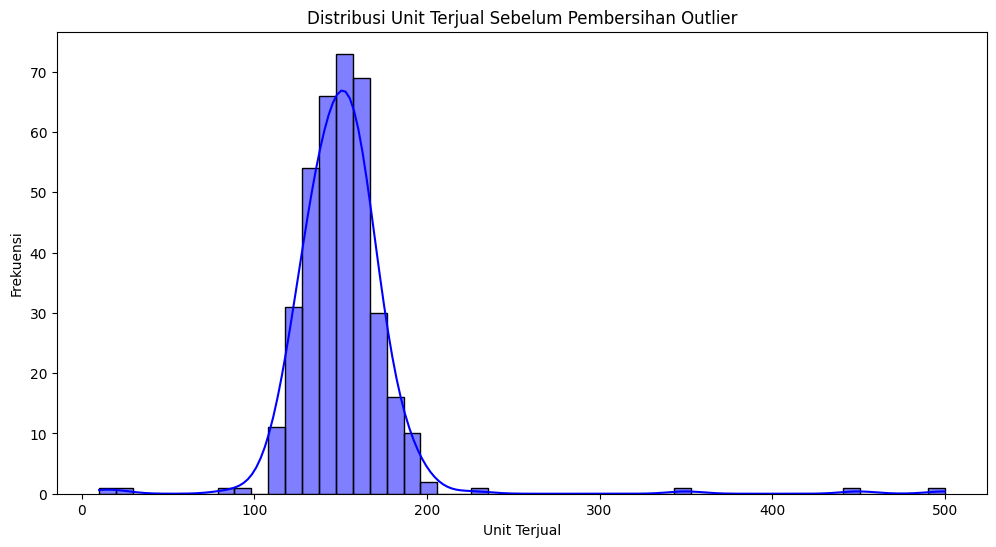


Jumlah data penjualan sebelum filter: 370
Jumlah data penjualan setelah filter: 362

=== Analisis Setelah Pembersihan Outlier ===
       Unit Terjual
count    362.000000
mean     149.502762
std       18.097803
min       97.000000
25%      136.000000
50%      150.500000
75%      162.000000
max      199.000000


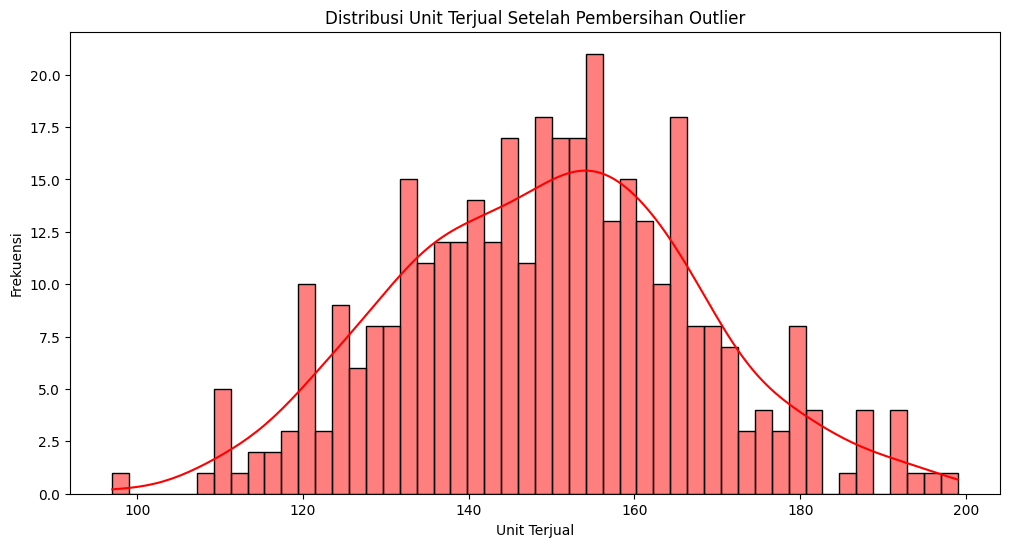

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# --- 1: Analisis dan Prediksi Penjualan Kopi Harian Menggunakan Neural Network ---

# Baca data dari dua file
try:
    df1 = pd.read_csv('/kaggle/input/coffee-sales/index_1.csv')
    df2 = pd.read_csv('/kaggle/input/coffee-sales/index_2.csv')

    # Gabungkan data
    df = pd.concat([df1, df2], ignore_index=True)

    # Konversi kolom 'date' ke format datetime
    df['date'] = pd.to_datetime(df['date'])

    # Hitung total penjualan per hari
    df_harian = df.groupby(df['date'].dt.date)['money'].sum().reset_index()
    df_harian.columns = ['tanggal', 'penjualan']

    # Ubah ke format numerik dan normalisasi
    data = df_harian['penjualan'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Buat data latih untuk model time series (1 hari sebelumnya -> prediksi hari berikutnya)
    X, y = [], []
    for i in range(len(data_scaled) - 1):
        X.append(data_scaled[i])
        y.append(data_scaled[i + 1])
    X = np.array(X)
    y = np.array(y)

    # Bagi data latih dan uji
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Bangun dan latih model Neural Network
    model = Sequential()
    model.add(Input(shape=(1,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, verbose=0)

    # Prediksi penjualan
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Visualisasi hasil prediksi
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='Aktual')
    plt.plot(y_pred_inv, label='Prediksi')
    plt.title('Prediksi Penjualan Harian')
    plt.xlabel('Hari')
    plt.ylabel('Penjualan (Rp)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Prediksi penjualan besok: Rp {:.2f}".format(scaler.inverse_transform(model.predict(data_scaled[-1].reshape(1,1)))[0][0]))

except FileNotFoundError as e:
    print(f"Error: Pastikan file {e.filename} ada di direktori yang benar.")

print("\n" + "="*70 + "\n")

# --- 2: Penerapan Metode IQR untuk Pembersihan Outlier pada Data Simulasi ---

# Simulasi data penjualan harian "Kopi Premium"
np.random.seed(42)
unit_terjual_normal = np.random.normal(loc=150, scale=20, size=365).astype(int)
outliers_unit = [500, 450, 20, 10, 350]
unit_terjual_final = np.concatenate((unit_terjual_normal, outliers_unit))
df_outlier = pd.DataFrame({'Unit Terjual': unit_terjual_final})
df_outlier = df_outlier.sort_values(by='Unit Terjual').reset_index(drop=True)

print("=== Analisis Sebelum Pembersihan Outlier ===")
print(df_outlier.describe())

# Visualisasi distribusi sebelum pembersihan
plt.figure(figsize=(12, 6))
sns.histplot(df_outlier['Unit Terjual'], bins=50, kde=True, color='blue')
plt.title('Distribusi Unit Terjual Sebelum Pembersihan Outlier')
plt.xlabel('Unit Terjual')
plt.ylabel('Frekuensi')
plt.show()

# Proses pembersihan outlier menggunakan metode IQR
Q1 = df_outlier['Unit Terjual'].quantile(0.25)
Q3 = df_outlier['Unit Terjual'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_outlier[(df_outlier['Unit Terjual'] >= lower_bound) & (df_outlier['Unit Terjual'] <= upper_bound)]

print(f"\nJumlah data penjualan sebelum filter: {len(df_outlier)}")
print(f"Jumlah data penjualan setelah filter: {len(df_filtered)}")

# Analisis dan visualisasi setelah pembersihan
print("\n=== Analisis Setelah Pembersihan Outlier ===")
print(df_filtered.describe())

# Visualisasi distribusi setelah pembersihan
plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['Unit Terjual'], bins=50, kde=True, color='red')
plt.title('Distribusi Unit Terjual Setelah Pembersihan Outlier')
plt.xlabel('Unit Terjual')
plt.ylabel('Frekuensi')
plt.show()